In [1]:
import prior
dataset = prior.load_dataset("procthor-10k")

house = dataset["train"][20]

AE: https://api.github.com/repos/allenai/procthor-10k/commits?sha=main
[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9223.36it/s]


In [3]:
print(house)
rooms = []
for room in house["rooms"]:
    room_poly = [(corner["x"], corner["z"]) for corner in room["floorPolygon"]]
    #print(room["roomType"] + " # " + str(room["floorPolygon"]))
    #print(room["roomType"] + " ?? " + str(room_poly))
    rooms.append((room["roomType"], room_poly))

print(rooms)

for room in rooms:
    print(room[1])

{'doors': [{'assetId': 'Doorway_Double_7', 'id': 'door|4|5', 'openable': True, 'openness': 1, 'room0': 'room|5', 'room1': 'room|4', 'wall0': 'wall|5|8.35|0.00|8.35|6.68', 'wall1': 'wall|4|8.35|0.00|8.35|6.68', 'holePolygon': [{'x': 4.353640555830781, 'y': 0, 'z': 0}, {'x': 6.301061391325776, 'y': 2.0971285314299166, 'z': 0}], 'assetPosition': {'x': 5.32681868454266, 'y': 1.0462727337144315, 'z': 0}}, {'assetId': 'Doorway_5', 'id': 'door|6|7', 'openable': True, 'openness': 1, 'room0': 'room|7', 'room1': 'room|6', 'wall0': 'wall|7|6.68|10.02|6.68|11.69', 'wall1': 'wall|6|6.68|10.02|6.68|11.69', 'holePolygon': [{'x': 0.5769642321808005, 'y': 0, 'z': 0}, {'x': 1.6145027606231834, 'y': 2.0979503514245152, 'z': 0}], 'assetPosition': {'x': 1.0944141168562438, 'y': 1.0459483740851283, 'z': 0}}, {'assetId': 'Doorway_5', 'id': 'door|4|6', 'openable': True, 'openness': 1, 'room0': 'room|4', 'room1': 'room|6', 'wall0': 'wall|4|8.35|6.68|13.36|6.68', 'wall1': 'wall|6|8.35|6.68|13.36|6.68', 'holePol

In [78]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))

def is_point_inside_room(point_to_test, room_polygon):
    (x, y, z) = point_to_test
    point = Point(x, z)
    polygon = Polygon(room_polygon)
    return polygon.contains(point)

def what_room_is_point_in(rooms, point):
    for room in rooms:
        if is_point_inside_room(point, room[1]):
            return room[0]
    return "NONE"

True


In [34]:
import glob
import pickle

def process_scene_files(llm_type):
    #pkl_mistral = "pkl_mistral/diff*.pkl"
    pkl_store = "experiment_data/pkl_" + llm_type + "/scene_descr_train_*.pkl"
    #print(glob.glob(pkl_gemma)) 

    accuracies_per_room_llm = []
    accuracies_per_room_svc = []
    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes

    # per all rooms
    all_rooms_llm_good = 0
    all_rooms_svc_good = 0
    all_rooms_elapsed_time_llm = 0
    all_rooms_elapsed_time_svc = 0
    all_rooms_total_points = 0
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #print(scene_f)

        room_points = scene.get_all_points()

#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }

        # per room
        llm_good = 0
        svc_good = 0
        elapsed_time_llm = 0
        elapsed_time_svc = 0
        total_points = 0
        
        for rp in room_points:
            total_points += 1
            all_rooms_total_points += 1
            if rp["room_type_gt"] == rp["room_type_llm"]:
                llm_good += 1
                all_rooms_llm_good += 1
                print(rp["room_type_llm"].name + " # " + rp["room_type_svc"].name + " # " + rp["room_type_gt"].name + " # " + str(rp["elapsed_time_llm"]) + " # " + str(rp["elapsed_time_svc"]))
                print(rp["visible_object_names"])
            
            if rp["room_type_gt"] == rp["room_type_svc"]:
                svc_good += 1
                all_rooms_svc_good += 1

            elapsed_time_llm += rp["elapsed_time_llm"]
            elapsed_time_svc += rp["elapsed_time_svc"]
            all_rooms_elapsed_time_llm += rp["elapsed_time_llm"]
            all_rooms_elapsed_time_svc += rp["elapsed_time_svc"]

        print("llm_good = " + str(llm_good / total_points) + " # " + "svc_good = " + str(svc_good / total_points) + " # llm_time_avg = " + str(elapsed_time_llm / total_points) + " # svc_time_avg = " + str(elapsed_time_svc / total_points))

        accuracies_per_room_llm.append(llm_good / total_points)
        accuracies_per_room_svc.append(svc_good / total_points)
        
        f.close()
        #print("\n")

    print("mean llm time: " + str(all_rooms_elapsed_time_llm / all_rooms_total_points) + " mean svc time: " + str(all_rooms_elapsed_time_svc / all_rooms_total_points))
    
    return (accuracies_per_room_llm, accuracies_per_room_svc, (all_rooms_elapsed_time_llm / all_rooms_total_points), (all_rooms_elapsed_time_svc / all_rooms_total_points))
#scene_descr_llm_fname = "pkl_mistral/scene_descriptions_llm.pkl"
#scene_descr_svc_fname = "pkl_mistral/scene_descriptions_svc.pkl"
#if (os.path.isfile(scene_descr_llm_fname) and os.path.isfile(scene_descr_svc_fname)):
#    file_llm = open(scene_descr_llm_fname,'rb')
#    file_svc = open(scene_descr_svc_fname,'rb')
#    scene_descriptions_llm = pickle.load(file_llm)

#process_scene_files("mistral")
#process_scene_files("gemma")
process_scene_files("llama")

KITCHEN # KITCHEN # KITCHEN # 11.07316 # 0.00106
{'Stool', 'CounterTop', 'Doorway', 'Wall'}
KITCHEN # KITCHEN # KITCHEN # 15.77715 # 0.00094
{'Stool', 'Shelf', 'CounterTop', 'Wall', 'Doorway', 'Drawer'}
KITCHEN # KITCHEN # KITCHEN # 14.7296 # 0.00106
{'Stool', 'CounterTop', 'Wall', 'HousePlant', 'GarbageCan'}
BEDROOM # BEDROOM # BEDROOM # 16.10965 # 0.00111
{'Bed', 'Window', 'AlarmClock', 'Wall'}
BEDROOM # BEDROOM # BEDROOM # 11.19697 # 0.00121
{'Bed', 'CD', 'Wall', 'Painting', 'Drawer', 'Dresser', 'AlarmClock', 'Pillow'}
BEDROOM # BEDROOM # BEDROOM # 13.80509 # 0.00106
{'Bed', 'CD', 'Wall', 'Floor', 'Painting', 'Drawer', 'Dresser'}
BEDROOM # BEDROOM # BEDROOM # 13.77772 # 0.00108
{'Bed', 'Wall', 'Doorway', 'Floor', 'SideTable', 'Mug'}
BEDROOM # BEDROOM # BEDROOM # 10.63824 # 0.00105
{'Bed', 'Wall', 'HousePlant', 'Chair', 'Statue', 'DiningTable', 'Window'}
BEDROOM # BEDROOM # BEDROOM # 8.39431 # 0.00111
{'Bed', 'Window', 'Wall'}
BEDROOM # LIVING_ROOM # BEDROOM # 12.26542 # 0.00107
{'CD

([0.676923076923077,
  0.6296296296296297,
  0.78125,
  0.7411764705882353,
  0.6923076923076923,
  0.6929133858267716,
  0.7238805970149254,
  0.7388059701492538,
  0.5882352941176471,
  0.6936416184971098,
  0.7803030303030303,
  0.6510067114093959,
  0.6864406779661016,
  0.8493975903614458,
  0.6712328767123288,
  0.7,
  0.6871794871794872,
  0.6862745098039216,
  0.6606060606060606,
  0.6049382716049383,
  0.6291390728476821,
  0.6571428571428571,
  0.777027027027027,
  0.6442307692307693,
  0.7598039215686274],
 [0.6923076923076923,
  0.4691358024691358,
  0.734375,
  0.6764705882352942,
  0.6730769230769231,
  0.6771653543307087,
  0.6865671641791045,
  0.6865671641791045,
  0.6102941176470589,
  0.5722543352601156,
  0.5757575757575758,
  0.5503355704697986,
  0.576271186440678,
  0.7108433734939759,
  0.5205479452054794,
  0.7333333333333333,
  0.6615384615384615,
  0.6078431372549019,
  0.6,
  0.5185185185185185,
  0.5033112582781457,
  0.5904761904761905,
  0.777027027027027

KITCHEN # KITCHEN # KITCHEN # 3.42804 # 0.00091
{'Wall', 'CounterTop', 'Stool', 'Doorway'}
KITCHEN # BEDROOM # KITCHEN # 3.68923 # 0.00098
{'Shelf', 'Wall', 'Doorway', 'ShelvingUnit', 'Drawer'}
KITCHEN # KITCHEN # KITCHEN # 4.66531 # 0.00099
{'Stool', 'Shelf', 'CounterTop', 'Wall', 'Doorway', 'Drawer'}
KITCHEN # KITCHEN # KITCHEN # 4.25943 # 0.00099
{'Stool', 'CounterTop', 'Wall', 'HousePlant', 'GarbageCan'}
BEDROOM # BEDROOM # BEDROOM # 4.0813 # 0.00098
{'Bed', 'Window', 'AlarmClock', 'Wall'}
BEDROOM # BEDROOM # BEDROOM # 4.82068 # 0.00096
{'Bed', 'CD', 'Wall', 'Painting', 'Drawer', 'Dresser', 'AlarmClock', 'Pillow'}
BEDROOM # BEDROOM # BEDROOM # 4.14809 # 0.00101
{'Bed', 'CD', 'Wall', 'Floor', 'Painting', 'Drawer', 'Dresser'}
BEDROOM # BEDROOM # BEDROOM # 4.98134 # 0.00119
{'Bed', 'Wall', 'Doorway', 'Floor', 'SideTable', 'Mug'}
BEDROOM # BEDROOM # BEDROOM # 3.2078 # 0.00098
{'Bed', 'Window', 'Wall'}
BEDROOM # LIVING_ROOM # BEDROOM # 5.48707 # 0.00098
{'CD', 'Doorway', 'Wall', 'Basket

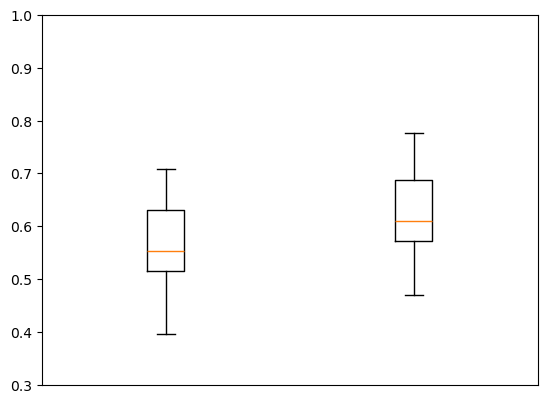

KITCHEN # KITCHEN # KITCHEN # 2.5712 # 0.00093
{'Stool', 'CounterTop', 'Doorway', 'Wall'}
KITCHEN # KITCHEN # KITCHEN # 4.67555 # 0.00088
{'Stool', 'Shelf', 'CounterTop', 'Wall', 'Doorway', 'Drawer'}
KITCHEN # KITCHEN # KITCHEN # 4.52939 # 0.00086
{'Stool', 'CounterTop', 'Wall', 'HousePlant', 'GarbageCan'}
BEDROOM # BEDROOM # BEDROOM # 1.64598 # 0.00086
{'Bed', 'Window', 'AlarmClock', 'Wall'}
BEDROOM # BEDROOM # BEDROOM # 4.23692 # 0.00089
{'Bed', 'CD', 'Wall', 'Painting', 'Drawer', 'Dresser', 'AlarmClock', 'Pillow'}
BEDROOM # BEDROOM # BEDROOM # 2.25182 # 0.00091
{'Bed', 'CD', 'Wall', 'Floor', 'Painting', 'Drawer', 'Dresser'}
BEDROOM # BEDROOM # BEDROOM # 4.32974 # 0.00109
{'Bed', 'Wall', 'Doorway', 'Floor', 'SideTable', 'Mug'}
BEDROOM # BEDROOM # BEDROOM # 2.84738 # 0.00092
{'Bed', 'Wall', 'HousePlant', 'Chair', 'Statue', 'DiningTable', 'Window'}
BEDROOM # BEDROOM # BEDROOM # 1.86506 # 0.00086
{'Bed', 'Window', 'Wall'}
BEDROOM # LIVING_ROOM # BEDROOM # 4.20102 # 0.00086
{'CD', 'Wall'

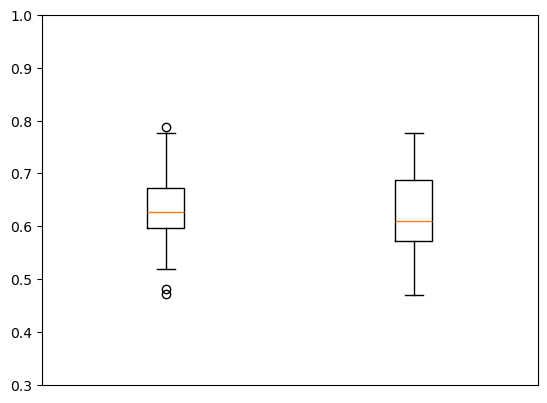

KITCHEN # KITCHEN # KITCHEN # 3.42804 # 0.00091
{'Wall', 'CounterTop', 'Stool', 'Doorway'}
KITCHEN # BEDROOM # KITCHEN # 3.68923 # 0.00098
{'Shelf', 'Wall', 'Doorway', 'ShelvingUnit', 'Drawer'}
KITCHEN # KITCHEN # KITCHEN # 4.66531 # 0.00099
{'Stool', 'Shelf', 'CounterTop', 'Wall', 'Doorway', 'Drawer'}
KITCHEN # KITCHEN # KITCHEN # 4.25943 # 0.00099
{'Stool', 'CounterTop', 'Wall', 'HousePlant', 'GarbageCan'}
BEDROOM # BEDROOM # BEDROOM # 4.0813 # 0.00098
{'Bed', 'Window', 'AlarmClock', 'Wall'}
BEDROOM # BEDROOM # BEDROOM # 4.82068 # 0.00096
{'Bed', 'CD', 'Wall', 'Painting', 'Drawer', 'Dresser', 'AlarmClock', 'Pillow'}
BEDROOM # BEDROOM # BEDROOM # 4.14809 # 0.00101
{'Bed', 'CD', 'Wall', 'Floor', 'Painting', 'Drawer', 'Dresser'}
BEDROOM # BEDROOM # BEDROOM # 4.98134 # 0.00119
{'Bed', 'Wall', 'Doorway', 'Floor', 'SideTable', 'Mug'}
BEDROOM # BEDROOM # BEDROOM # 3.2078 # 0.00098
{'Bed', 'Window', 'Wall'}
BEDROOM # LIVING_ROOM # BEDROOM # 5.48707 # 0.00098
{'CD', 'Doorway', 'Wall', 'Basket

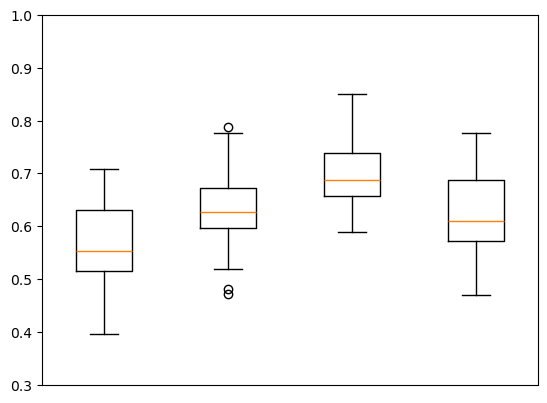

gemma_mean_time = 5.447181233855467
mistral4b_mean_time = 4.8781057735641635
llama_mean_time = 15.48073921956582
svc_mean_time = 0.001060590821654307


In [35]:
import matplotlib.pyplot as plt
import numpy as np

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
def testRoomClassifierAccuracy(llm_type):
    (llm_accuracies, svc_accuracies, llm_mean_time, svc_mean_time) = process_scene_files(llm_type)
    # should be two volumes -- one for LLM and one for SVC for accuracies compared to ground truth.
    number_of_dataset_volumes = 2

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(llm_accuracies)

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = llm_accuracies
    dataset_test_results[1] = svc_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)
    #print(dataset_test_results)
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    #ax7.set_title("Variance while " + operation + " " + gesture + " gesture")
    #if (model_type == ModelType.HYBRID_AT_12):
    #    ax.set_title("Sunrgbd - Hybridized with AI2-THOR data")
    #elif (model_type == ModelType.HYBRID_AT_18):
    #    ax.set_title("Scannet - Hybridized with AI2-THOR data")
    ax.boxplot(dataset_test_results)
    plt.ylim(0.3, 1.0)
    plt.show()

testRoomClassifierAccuracy("gemma")
testRoomClassifierAccuracy("mistral")

##
# This function will create a box plot for a hybridized data set (HYBRID_AT_12 or HYBRID_AT_18)
##
def testAllRoomClassifiersAccuracy():
    (gemma_accuracies, svc_accuracies, gemma_mean_time, svc_mean_time) = process_scene_files("gemma")
    (mistral_accuracies, svc_accuracies, mistral4b_mean_time, svc_mean_time) = process_scene_files("mistral")
    (llama_accuracies, svc_accuracies, llama_mean_time, svc_mean_time) = process_scene_files("llama")
    # should be two volumes -- one for LLM and one for SVC for accuracies compared to ground truth.
    number_of_dataset_volumes = 4

    # How many rooms were classified
    number_of_tests_per_dataset_volume = len(svc_accuracies)

    # We'll create an empty Numpy array and put the our SVC accuracies into there.
    dataset_test_results = np.zeros(shape=(number_of_dataset_volumes, number_of_tests_per_dataset_volume))
    #print(dataset_test_results.shape)

    dataset_test_results[0] = gemma_accuracies
    dataset_test_results[1] = mistral_accuracies
    dataset_test_results[2] = llama_accuracies
    dataset_test_results[3] = svc_accuracies

    # transpose it because I imagined it differently to how matplotlib needs the data
    dataset_test_results = np.transpose(dataset_test_results)
    #print(dataset_test_results)
    fig, ax = plt.subplots()
    ax.axes.get_xaxis().set_visible(False)
    #ax7.set_title("Variance while " + operation + " " + gesture + " gesture")
    #if (model_type == ModelType.HYBRID_AT_12):
    #    ax.set_title("Sunrgbd - Hybridized with AI2-THOR data")
    #elif (model_type == ModelType.HYBRID_AT_18):
    #    ax.set_title("Scannet - Hybridized with AI2-THOR data")
    ax.boxplot(dataset_test_results)
    plt.ylim(0.3, 1.0)
    plt.show()

    print("gemma_mean_time = " + str(gemma_mean_time))
    print("mistral4b_mean_time = " + str(mistral4b_mean_time))
    print("llama_mean_time = " + str(llama_mean_time))
    print("svc_mean_time = " + str(svc_mean_time))

testAllRoomClassifiersAccuracy()

In [44]:
from ae_gemma_llm import GemmaLLMControl
from room_type import RoomType
from scene_description import ClassifierType

glc = GemmaLLMControl()

def getAllVisibleObjectNamesInThisRoom(scene, classifier_type, rt):
  points = scene.get_all_points_of_room_type(classifier_type, rt)
  ret_set = set()
  for p in points:
      ret_set = ret_set.union(p["visible_object_names"])

  return ret_set

def process_scene_files(llm_type):
    pkl_store = "experiment_data/pkl_" + llm_type + "/scene_descr_train_*.pkl"    
    scene_files = glob.glob(pkl_store) # files showing gemma scenes
    
    for scene_f in scene_files:
        f = open(scene_f,'rb')
        scene = pickle.load(f)
        #obj_names = scene.getAllVisibleObjectNamesInThisRoom(ClassifierType.LLM, RoomType.KITCHEN)
        #points = scene.get_all_points_of_room_type(ClassifierType.LLM, RoomType.KITCHEN)
        print(getAllVisibleObjectNamesInThisRoom(scene, ClassifierType.LLM, RoomType.KITCHEN))
        
#        for p in points:
            #print(p)
#            print(p["visible_object_names"])
        #print("KITCHEN: " + str(obj_names))
        #glc.construct_object_selector_question_ranking("fresh bottle of beer", )
        
#    new_point = {
#        "point_pose" : point_pose,
#        "room_type_llm" : room_type_llm,
#        "room_type_svc" : room_type_svc,
#        "room_type_gt" : room_type_gt,
#        "visible_objects_at_this_point" : visible_objects_at_this_point,
#        "visible_object_names" : set(),
#        "elapsed_time_llm": elapsed_time_llm,
#        "elapsed_time_svc": elapsed_time_svc
#    }
        f.close()

process_scene_files("llama")

{'Shelf', 'Doorway', 'Wall', 'HousePlant', 'Bowl', 'Vase', 'CreditCard', 'Toaster', 'DishSponge', 'Mug', 'Window', 'Bread', 'Stool', 'CounterTop', 'CoffeeMachine', 'Pen', 'DeskLamp', 'Chair', 'DiningTable', 'Pot', 'Floor', 'SaltShaker', 'SideTable', 'Fridge', 'ShelvingUnit', 'Drawer', 'GarbageCan', 'ButterKnife'}
{'Sink', 'Faucet', 'SinkBasin', 'Wall', 'Doorway', 'BasketBall', 'Box', 'Painting', 'GarbageCan'}
{'Wall', 'Doorway', 'HousePlant', 'Safe', 'Vase', 'Tomato', 'Potato', 'Painting', 'Window', 'SoapBottle', 'Fork', 'Bread', 'CounterTop', 'Doorframe', 'Pencil', 'DiningTable', 'Cart', 'Laptop', 'Floor', 'SaltShaker', 'Fridge'}
{'Faucet', 'SprayBottle', 'Candle', 'Tomato', 'Vase', 'CellPhone', 'Egg', 'Painting', 'Window', 'Cup', 'Apple', 'Pan', 'Chair', 'Floor', 'GarbageBag', 'Bottle', 'RemoteControl', 'GarbageCan', 'KeyChain', 'Sink', 'Doorway', 'Wall', 'HousePlant', 'Bowl', 'Book', 'Plate', 'Mug', 'Fork', 'SinkBasin', 'CounterTop', 'DiningTable', 'Cart', 'Fridge', 'CoffeeMachine',

In [4]:
from ae_llm import LLMControl, LLMType

lc = LLMControl(LLMType.MISTRAL_6b)

lc.construct_object_selector_question_ranking("fresh bottle of beer", {'SprayBottle', 'Shelf', 'Wall', 'BaseballBat', 'Bowl', 'HousePlant', 'Doorway', 'Plate', 'Vase', 'Potato', 'Toaster', 'ArmChair', 'Painting', 'Window', 'Apple', 'CounterTop', 'Chair', 'Pencil', 'DiningTable', 'Cart', 'Floor', 'GarbageBag', 'Fridge', 'ShelvingUnit', 'Drawer', 'WineBottle'})
lc.get_object_selector_answer()

3
 LLM :mistral:7b-instruct-v0.2-q6_K
3
 Based on the given context, a fresh bottle of beer is most likely to be found near a Fridge. The reason for this is that refrigerators are commonly used to store beer, as the cool temperature helps preserve the carbonation and freshness of the beer. Therefore, a fresh bottle of beer would typically be found in or nearby a fridge.

Ranking of objects from most likely to least likely to be near a fresh bottle of beer:
1. Fridge
2. Shelving Unit (for storing beer bottles)
3. CounterTop (where one might open and pour the beer)
4. Table (such as a dining table or coffee table, where one might drink the beer)
5. Floor (if the bottle was accidentally dropped)
6. Cart (used to transport heavy items such as cases of beer)
7. Wall (as in a beer tap wall or beer fridge built into a wall)
8. SprayBottle (unrelated)
9. Vase (unrelated)
10. HousePlant (unrelated)
11. Shelf (while beer can be stored on shelves, it is more likely to be found in a refrigerator o

In [4]:
from ae_llm import LLMControl, LLMType

lc = LLMControl(LLMType.GEMMA)

lc.initialise_for_ai2_thor_room_classification()
lc.get_answer_structured_qry()

Reasoning : Candle is commonly used for lighting in bathrooms and a plunger , scrub brush and toilet are typical cleaning supplies found in bathrooms. Therefore I would guess that I am in a bathroom.
Answer : 4